# Data Source
https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv
# Dataset Description
## Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.
## Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. 

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

The dataset has undergone PCA Transformation. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

# Project Objectives
- To identify fraudulent credit card transactions
# Methodologies
- To let the models accurately detect fraud, we need to undersample the data.
    - equal ratio for fraud and not fraud (1:1)
- To find the best classifier
## Remarks
- Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

# Step 1: Import Required Libraries and Data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats 
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold,RandomizedSearchCV
from sklearn.metrics import roc_curve, recall_score
import sklearn.metrics as metrics


# Undersampling
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline


# Clustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Classifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier


# Cross Validation
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score


# Learning Curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit



## Import Data

In [38]:
df = pd.read_csv('creditcard.csv')

As mentioned by the dataset, the v1 - v28 features has been rescaled before the PCA transformation. So the only features that require scaling are 'Time' and 'Amount'.

In [39]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [40]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


# Step 2:  Check for missing data

In [41]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

We have no missing data in this dataset.

# Step 3: Explore Data
## Imbalanced Data : Fraud and Not Fraud

Not Fraud: 99.83%
Fraud: 0.17%


Text(0.5, 1.0, 'Not Fraud (0) vs Fraud (1)')

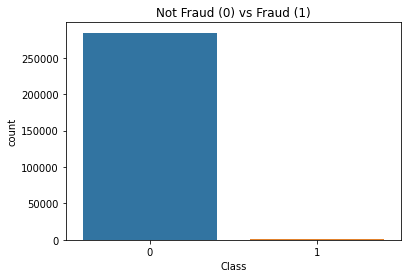

In [42]:
fraud_cnt = df.Class.value_counts()
print('Not Fraud: {}%'.format(round(fraud_cnt[0] / sum(fraud_cnt) * 100, 2)))
print('Fraud: {}%'.format(round(fraud_cnt[1] / sum(fraud_cnt) * 100, 2)))
sns.countplot('Class', data = df)
plt.title('Not Fraud (0) vs Fraud (1)')

With no suprise, the fraud and not fraud data are seriously imbalanced.

## Explore the distribution of time and amount

Text(0.5, 1.0, 'Transaction Time')

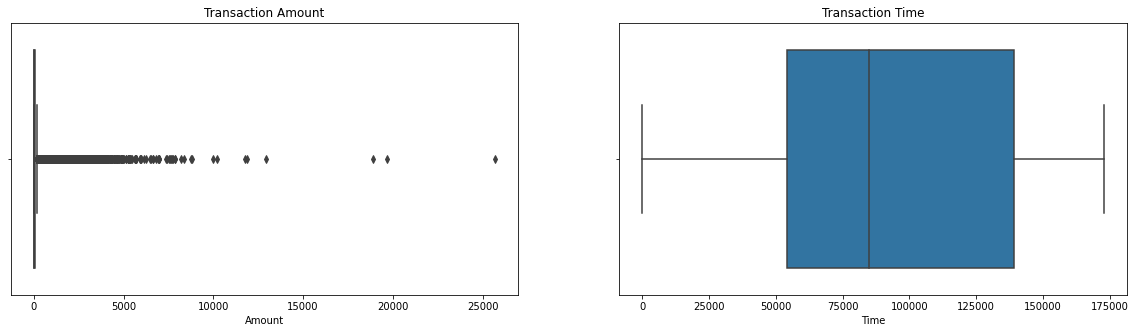

In [43]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.boxplot(df['Amount'], ax = ax[0]).set_title('Transaction Amount')
sns.boxplot(df['Time'], ax = ax[1]).set_title('Transaction Time')

As shown here, the distribution of transaction amount is right-skewed. To reduce the outliner effect, I am going to use Robust Scaler to scale the 'Time' and 'Amount'. 

# Step 4: Scale the Transaction Time and Amount data
As there are some outliers in 'Amount', RobustScaler is used to reduce the effect caused by outliers. The scaler removes median and scales the data according to the interquartile range. 

In [44]:
scaler = RobustScaler()
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))

# Methodologies
I am going to try out both undersampling and oversampling techniques to balance the data to see which sampling techniques give the best accuracy to the predicted results. As the dataset is highly imbalanced, undersampling/oversampling is required in order to prevent the model from overfitting and able to detect fraud transaction. Otherwise, the model will be biased towards majority class (i.e. Not Fraud).


## Step 5.1 - Method 1 : Undersample training set Before CV (The Wrong Way)
Random undersampling is used to undersample the majority class.
#### Remarks
I undersampled the training data in the wrong way, while method 2 is the correct way to do undersampling. In this wrong method, data are undersampled before splitting the training and testing data, in which I should only resampled the training data instead. The training set and validation set will share the same sample, which leads to overfitting and misleading results. Besides, I should only undersample the training data instead of the raw data. The reason I decided to keep this part is that I want to show the mistake that I made.
- Reference
    - https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
    - https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation

In [46]:
df = df.sample(frac=1)
new_df = pd.concat([df.loc[df['Class'] == 1],df.loc[df['Class'] == 0][:492]] )
new_df = new_df.sample(frac=1, random_state=42).reset_index().drop('index',axis = 1)

### Check out the Data Correlation
I want to explore the features that are positively or negatively correlated to Class. In this case, although these some features are correlated, they will not be removed as the column names are hidden because of privacy issues. 

Negative Relationship:
V14   -0.746833
V12   -0.683527
V10   -0.629472
V16   -0.602864
V9    -0.565214
Name: Class, dtype: float64
Positive Relationship:
V19      0.253494
V2       0.476505
V11      0.689498
V4       0.705101
Class    1.000000
Name: Class, dtype: float64


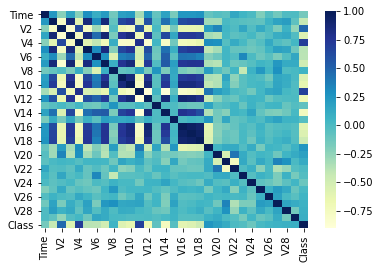

In [49]:
corr = new_df.corr().sort_values(by='Class')
print('Negative Relationship:\n{}'.format(corr['Class'].iloc[:5]))
print('Positive Relationship:\n{}'.format(corr['Class'].tail(5)))
sns.heatmap(new_df.corr(),cmap="YlGnBu")

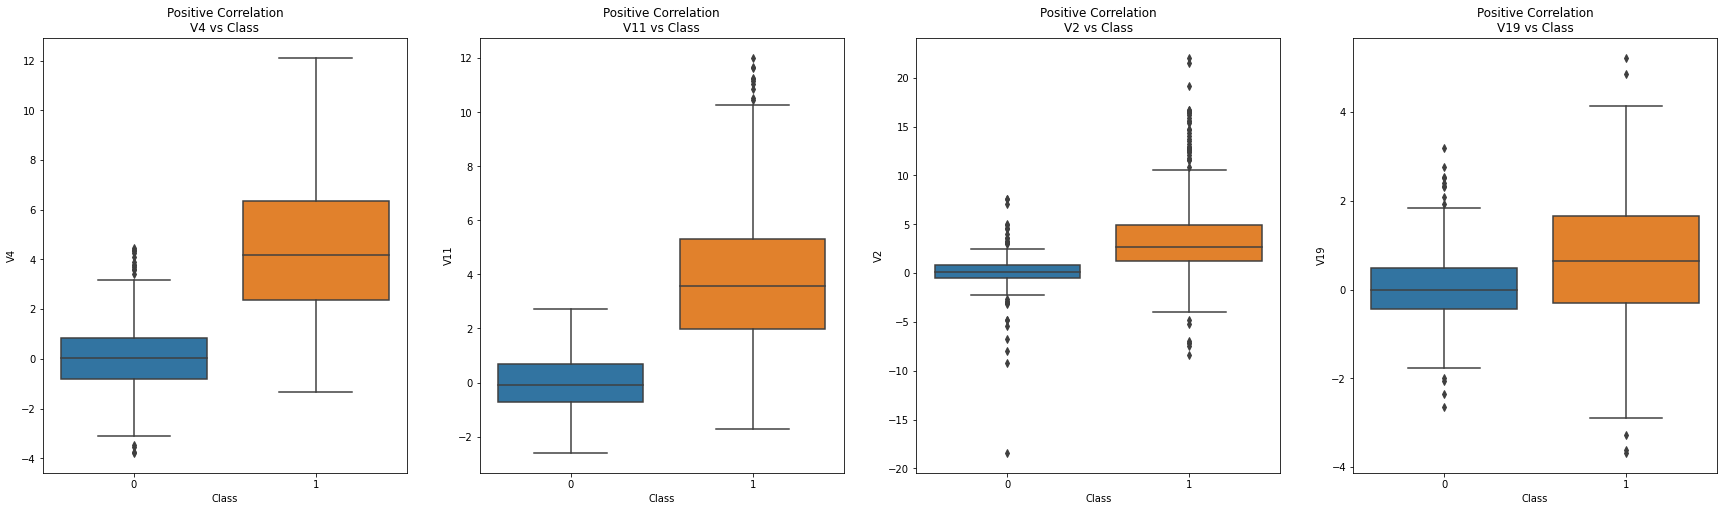

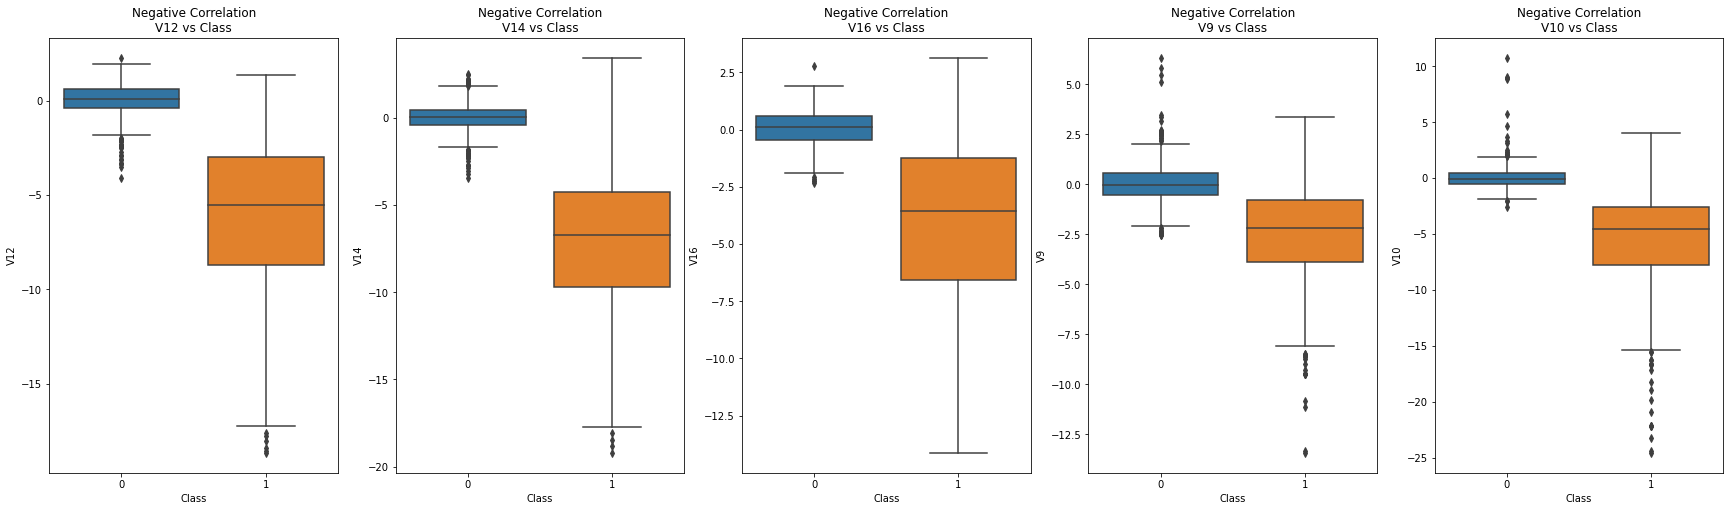

In [51]:
pos_neg_dict = {
    'Positive Correlation': ['V4','V11','V2','V19'],
    'Negative Correlation' : ['V12','V14','V16','V9','V10']
}
for corr, ls in pos_neg_dict.items():
    fig, ax = plt.subplots(ncols=len(ls), figsize=(30,8))
    for i, column in enumerate(ls):
        plot = sns.boxplot(x='Class', y=column, data=new_df, ax=ax[i]).set_title(corr + '\n' + column + ' vs Class')
    plt.show()

Positive Relationship with 'Class':
   - Heatmap: V2,V4,V11,V19 
   - Boxplot: The higher the value, the larger to chance to be a fraud transaction.

Negative Relationship with 'Class':
   - Heatmap: V12, V14, V16, V17, V10, V3
   - Boxplot: The lower the value, the larger to chance to be a fraud transaction.
#### Remarks:
As the feature names are unknown, I tend to leave them untouched.


In [52]:
x = new_df.drop('Class',axis=1)
y = new_df['Class']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state= 42)

# Classifiers
- I am going to try out the below algorithms:
    - Logistic regression
    - K-Nearest neighbors
    - Support Vector Classifier
    - Random Forest
    - AdaBoost
    - xgboost


In [62]:
classifiers = [
    ('logisticregression', LogisticRegression(),
     {'penalty': ['l1','l2'], 'C':[0.001,0.01,0.1,1,10,100,1000]}),
    ('randomforestclassifier',RandomForestClassifier(),
    {'n_estimators':[30,40,50],'max_depth': list(range(2,5))}),
    ('adaboostclassifier',AdaBoostClassifier(), {'n_estimators':[10,20,30,40,50,60]}),
     ('svc',SVC(),
     {'C':[0.5,0.7,0.9,1],'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'probability':[True]}),
    ('xgbclassifier', XGBClassifier(),{'max_depth':list(range(2,5)),'gamma':[0.001,0.01,0.1,1]}),
    ('kneighborsclassifier', KNeighborsClassifier(), 
     {'n_neighbors': list(range(2,11,2)), 'algorithm':['ball_tree','kd_tree','brute']}),
]
      

### Simple Classifier

In [54]:
for name, model, param in classifiers:
    model.fit(x_train,y_train)
    print('*'*60)
    print(name)
    for x in [x_train,x_test]:
        y_pred = model.predict(x)
        if x.equals(x_train):
            print("Training model Result:")
            y = y_train
        else:
            print("Testing model Result:")
            y = y_test
        score = accuracy_score(y,y_pred)
        print(f"Accuracy score: {score * 100 : .2f}%")
        print('-' * 60)
        print("Confusion Matrix")
        matrix = confusion_matrix(y,y_pred)
        print(matrix)
        print('-' * 60)
        print("Classification Report")
        print(classification_report(y,y_pred))
        print('#' * 60)

************************************************************
logisticregression
Training model Result:
Accuracy score:  95.68%
------------------------------------------------------------
Confusion Matrix
[[399   6]
 [ 28 354]]
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       405
           1       0.98      0.93      0.95       382

    accuracy                           0.96       787
   macro avg       0.96      0.96      0.96       787
weighted avg       0.96      0.96      0.96       787

############################################################
Testing model Result:
Accuracy score:  94.42%
------------------------------------------------------------
Confusion Matrix
[[ 85   2]
 [  9 101]]
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0    

### Hyperparameter Tuning

In [55]:
best = {}
for name, model, param in classifiers:
    grid_cv = RandomizedSearchCV(model,param,cv=10,refit=True)
    grid_cv.fit(x_train,y_train)
    y_pred = grid_cv.predict(x_test)
    test_accuracy = accuracy_score(y_test,y_pred)
    best[name] = {'Model': model,'Best Training Score': grid_cv.best_score_, 'Testing Score': test_accuracy,'Best Estimator': grid_cv.best_estimator_}
    

/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [56]:
best

{'logisticregression': {'Model': LogisticRegression(),
  'Best Training Score': 0.9428270042194093,
  'Testing Score': 0.9441624365482234,
  'Best Estimator': LogisticRegression(C=0.1)},
 'randomforestclassifier': {'Model': RandomForestClassifier(),
  'Best Training Score': 0.9313534566699124,
  'Testing Score': 0.9390862944162437,
  'Best Estimator': RandomForestClassifier(max_depth=4, n_estimators=50)},
 'adaboostclassifier': {'Model': AdaBoostClassifier(),
  'Best Training Score': 0.9377474845829277,
  'Testing Score': 0.9187817258883249,
  'Best Estimator': AdaBoostClassifier(n_estimators=40)},
 'svc': {'Model': SVC(),
  'Best Training Score': 0.9402953586497891,
  'Testing Score': 0.9441624365482234,
  'Best Estimator': SVC(C=0.5, kernel='linear', probability=True)},
 'xgbclassifier': {'Model': XGBClassifier(),
  'Best Training Score': 0.9453911067835119,
  'Testing Score': 0.9390862944162437,
  'Best Estimator': XGBClassifier(gamma=1)},
 'kneighborsclassifier': {'Model': KNeighbo

### Box Plot 

Average Score of logisticregression: 0.9441
Standard Deviation logisticregression : 0.0108
************************************************************
Average Score of randomforestclassifier: 0.9276
Standard Deviation randomforestclassifier : 0.0189
************************************************************
Average Score of adaboostclassifier: 0.9365
Standard Deviation adaboostclassifier : 0.0191
************************************************************
Average Score of svc: 0.9416
Standard Deviation svc : 0.0193
************************************************************
Average Score of xgbclassifier: 0.9416
Standard Deviation xgbclassifier : 0.0184
************************************************************
Average Score of kneighborsclassifier: 0.9403
Standard Deviation kneighborsclassifier : 0.0153
************************************************************


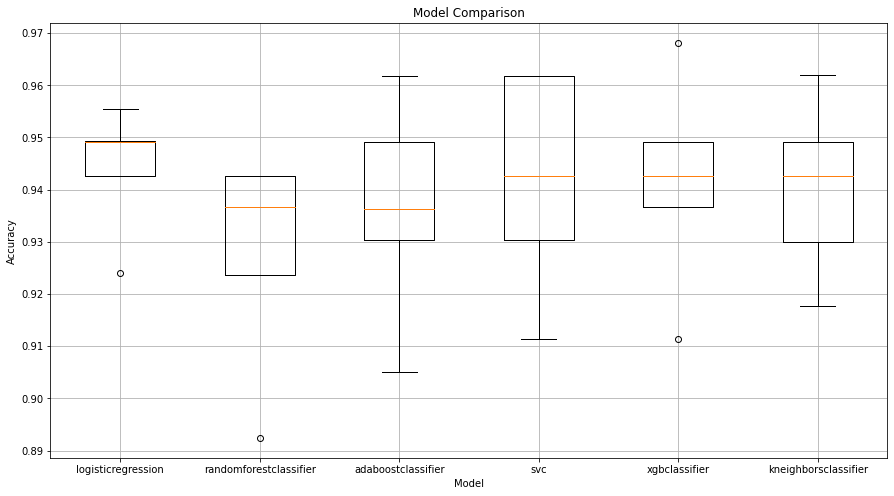

In [57]:
results = {}
for  i, name in list(zip(list(range(len(best))),best.items())):
    kfold = KFold(n_splits=5)
    cv_score = cross_val_score(name[1]['Best Estimator'], x_train,y_train,cv=kfold,scoring='accuracy')
    results[name[0]] = cv_score
    print(f'Average Score of {name[0]}: {cv_score.mean():.4f}')
    print(f'Standard Deviation {name[0]} : {cv_score.std():.4f}')
    print('*' * 60)
plt.figure(figsize=(15,8))
plt.boxplot(list(results.values()), labels=list(results.keys()))
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.grid()
plt.show()


### ROC Curve & PR Curve
As I undersampled the data in the wrong way, the fraud and Not Fraud Data ratio are in 1:1. So in this case, I should evaluate the model using ROC curve. 
#### Reference
- https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

logisticregression- Training Data:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       405
           1       0.99      0.92      0.95       382

    accuracy                           0.95       787
   macro avg       0.96      0.95      0.95       787
weighted avg       0.96      0.95      0.95       787

logisticregression- Testing Data:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        87
           1       0.98      0.92      0.95       110

    accuracy                           0.94       197
   macro avg       0.94      0.95      0.94       197
weighted avg       0.95      0.94      0.94       197



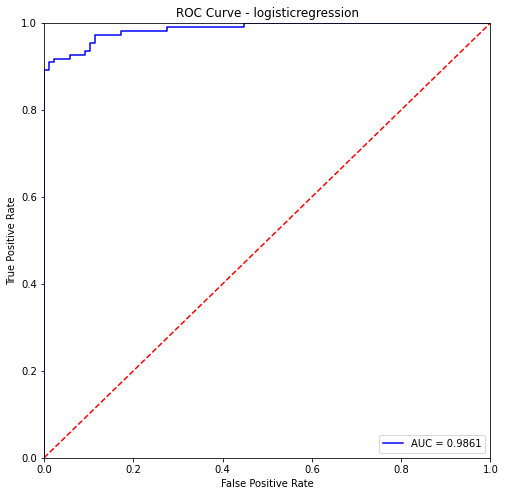

randomforestclassifier- Training Data:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       405
           1       1.00      0.88      0.94       382

    accuracy                           0.94       787
   macro avg       0.95      0.94      0.94       787
weighted avg       0.95      0.94      0.94       787

randomforestclassifier- Testing Data:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        87
           1       1.00      0.89      0.94       110

    accuracy                           0.94       197
   macro avg       0.94      0.95      0.94       197
weighted avg       0.95      0.94      0.94       197



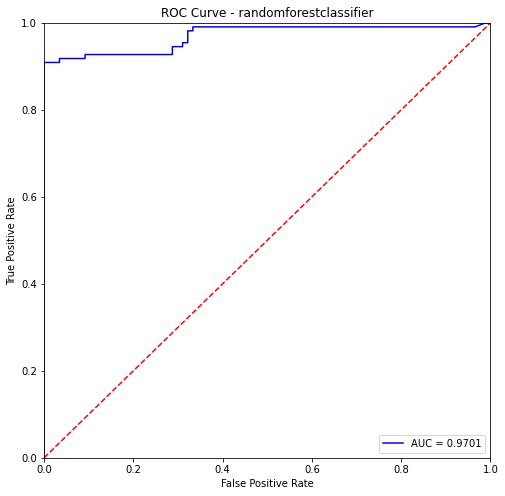

adaboostclassifier- Training Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       405
           1       0.99      0.98      0.99       382

    accuracy                           0.99       787
   macro avg       0.99      0.99      0.99       787
weighted avg       0.99      0.99      0.99       787

adaboostclassifier- Testing Data:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        87
           1       0.96      0.89      0.92       110

    accuracy                           0.92       197
   macro avg       0.92      0.92      0.92       197
weighted avg       0.92      0.92      0.92       197



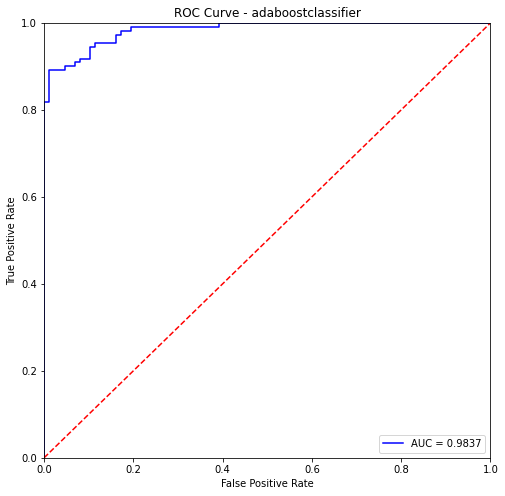

svc- Training Data:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       405
           1       0.99      0.92      0.95       382

    accuracy                           0.95       787
   macro avg       0.96      0.95      0.95       787
weighted avg       0.96      0.95      0.95       787

svc- Testing Data:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        87
           1       0.98      0.92      0.95       110

    accuracy                           0.94       197
   macro avg       0.94      0.95      0.94       197
weighted avg       0.95      0.94      0.94       197



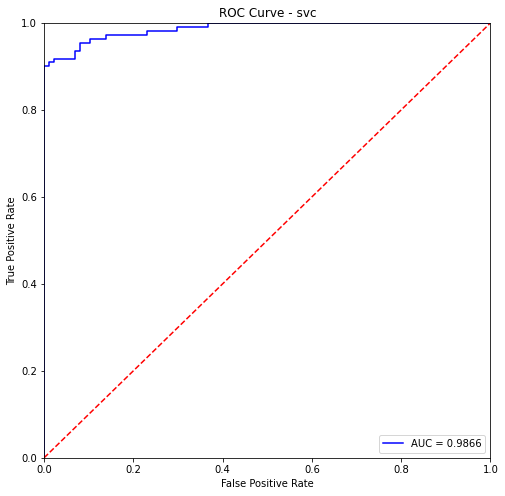

xgbclassifier- Training Data:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       405
           1       1.00      0.99      1.00       382

    accuracy                           1.00       787
   macro avg       1.00      1.00      1.00       787
weighted avg       1.00      1.00      1.00       787

xgbclassifier- Testing Data:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        87
           1       0.97      0.92      0.94       110

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197



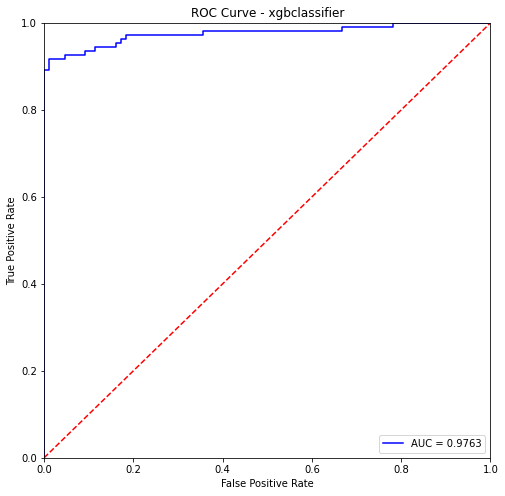

kneighborsclassifier- Training Data:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       405
           1       0.99      0.90      0.94       382

    accuracy                           0.95       787
   macro avg       0.95      0.95      0.95       787
weighted avg       0.95      0.95      0.95       787

kneighborsclassifier- Testing Data:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        87
           1       1.00      0.91      0.95       110

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197



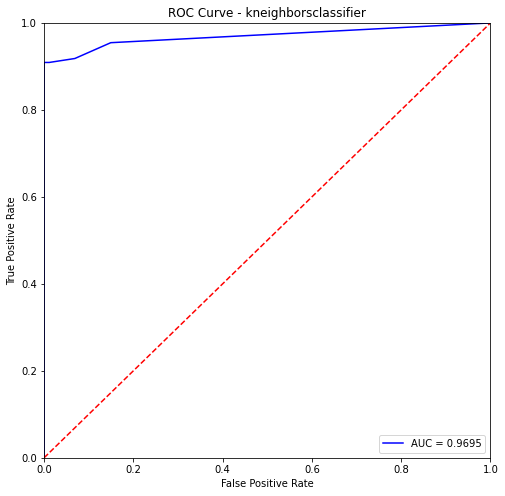

In [61]:
for  i, name in list(zip(list(range(len(best))),best.items())):
    model = name[1]['Best Estimator'].fit(x_train,y_train)
    print(f'{name[0]}- Training Data:\n{classification_report(y_train,model.predict(x_train))}')
    print(f'{name[0]}- Testing Data:\n{classification_report(y_test,model.predict(x_test))}')
    proba = model.predict_proba(x_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test,proba)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(8,8))
    plt.title(f'ROC Curve - {name[0]}')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


### Summary for  Method One 
Because of data leakage from training set to testing set, overfitting is resulted using undersampling technique before cross-validation. Among all models, LogidticRegression, AdaBoostClassifier and Support Vector Classifier seem to have the highest accuracy. But the accuracy sounds too good to be true.

In the coming steps, I am going to try out undersampling techniques during cross validation to see if i can get a higher accuracy score.

# New Dataset for below Methods

In [20]:
scaler = RobustScaler()
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
new_df = df

## Step 5.2 -  Method 2: Undersampling within Folds
The right way to do undersampling is to do cross validation when undersampling data. In each fold, we will firstly undersample the majority class, then train data with the fold training set and finally cross-validate data using the test set in each fold. 
For the undersampling algorithm, I used NearMiss to undersample only the majority class this time as it helps tackle the issue of potential information loss. In NearMiss, the n neighbors of the majority class that are closest to minority class are selected.
#### Reference
- https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
- https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8

In [21]:
classifiers = [
    ('logisticregression', LogisticRegression(),
     {'penalty': ['l1','l2'], 'C':[0.001,0.01,0.1,1,10,100,1000]}),
    ('randomforestclassifier',RandomForestClassifier(),
    {'n_estimators':[30,40,50],'max_depth': list(range(2,5))}),
    ('adaboostclassifier',AdaBoostClassifier(), {'n_estimators':[10,20,30,40,50,60]}),
     ('svc',SVC(),
     {'C':[0.5,0.7,0.9,1],'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'probability':[True]}),
    ('xgbclassifier', XGBClassifier(),{'max_depth':list(range(2,5)),'gamma':[0.001,0.01,0.1,1]}),
    ('kneighborsclassifier', KNeighborsClassifier(), 
     {'n_neighbors': list(range(2,11,2)), 'algorithm':['ball_tree','kd_tree','brute']}),
]

In [22]:
x = new_df.drop('Class',axis=1)
y = new_df['Class']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

### Find the best parameters for each model 
The best parameters are obtained through cross-validation when undersampling data. In the GridSearchCV, a pipeine is added in order to undersample the fold data and fit model with fold data.

In [23]:
kf = KFold(n_splits=3, random_state=42, shuffle=False)
model_dict = {}
for i, model in zip(list(range(len(classifiers))), classifiers):
    print(model[0])
    imba_pipeline = make_pipeline(NearMiss(sampling_strategy='majority'), model[1])
    new_params = {model[0] + '__' + key : model[2][key] for key in model[2] }
    grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='recall',return_train_score=True)
    grid_imba.fit(x_train,y_train)
    model_dict[model[0]] = {'Best param': grid_imba.best_params_,
                           'Best estimator': grid_imba.best_estimator_,
                           'Best training score' : grid_imba.best_score_,
                           'Model': model[1],
                           'Best testing score': recall_score(y_test,grid_imba.predict(x_test))}
    print(model_dict[model[0]])
    

/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


logisticregression


/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports

/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports

/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports

/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

{'Best param': {'logisticregression__C': 1, 'logisticregression__penalty': 'l2'}, 'Best estimator': Pipeline(steps=[('nearmiss', NearMiss(sampling_strategy='majority')),
                ('logisticregression', LogisticRegression(C=1))]), 'Best training score': 0.9465527438334078, 'Model': LogisticRegression(), 'Best testing score': 0.9405940594059405}
randomforestclassifier
{'Best param': {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 50}, 'Best estimator': Pipeline(steps=[('nearmiss', NearMiss(sampling_strategy='majority')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=4, n_estimators=50))]), 'Best training score': 0.9663854944519036, 'Model': RandomForestClassifier(), 'Best testing score': 0.9702970297029703}
adaboostclassifier
{'Best param': {'adaboostclassifier__n_estimators': 10}, 'Best estimator': Pipeline(steps=[('nearmiss', NearMiss(sampling_strategy='majority')),
                ('adaboostclassifi

In [24]:
model_dict

{'logisticregression': {'Best param': {'logisticregression__C': 1,
   'logisticregression__penalty': 'l2'},
  'Best estimator': Pipeline(steps=[('nearmiss', NearMiss(sampling_strategy='majority')),
                  ('logisticregression', LogisticRegression(C=1))]),
  'Best training score': 0.9465527438334078,
  'Model': LogisticRegression(),
  'Best testing score': 0.9405940594059405},
 'randomforestclassifier': {'Best param': {'randomforestclassifier__max_depth': 4,
   'randomforestclassifier__n_estimators': 50},
  'Best estimator': Pipeline(steps=[('nearmiss', NearMiss(sampling_strategy='majority')),
                  ('randomforestclassifier',
                   RandomForestClassifier(max_depth=4, n_estimators=50))]),
  'Best training score': 0.9663854944519036,
  'Model': RandomForestClassifier(),
  'Best testing score': 0.9702970297029703},
 'adaboostclassifier': {'Best param': {'adaboostclassifier__n_estimators': 10},
  'Best estimator': Pipeline(steps=[('nearmiss', NearMiss(sam

### Model Evaluation

logisticregression


/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


{'Best param': {'logisticregression__C': 1, 'logisticregression__penalty': 'l2'}, 'Best estimator': Pipeline(steps=[('nearmiss', NearMiss(sampling_strategy='majority')),
                ('logisticregression', LogisticRegression(C=1))]), 'Best training score': 0.9465527438334078, 'Model': LogisticRegression(), 'Best testing score': 0.9405940594059405}
Train Result:
              precision    recall  f1-score   support

           0       1.00      0.52      0.69    227454
           1       0.00      0.96      0.01       391

    accuracy                           0.52    227845
   macro avg       0.50      0.74      0.35    227845
weighted avg       1.00      0.52      0.69    227845



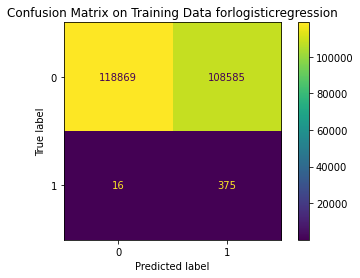

<Figure size 864x864 with 0 Axes>

Test Result:
              precision    recall  f1-score   support

           0       1.00      0.53      0.69     56861
           1       0.00      0.99      0.01       101

    accuracy                           0.53     56962
   macro avg       0.50      0.76      0.35     56962
weighted avg       1.00      0.53      0.69     56962



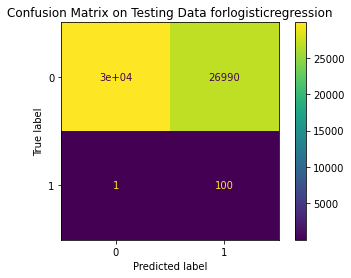

<Figure size 864x864 with 0 Axes>

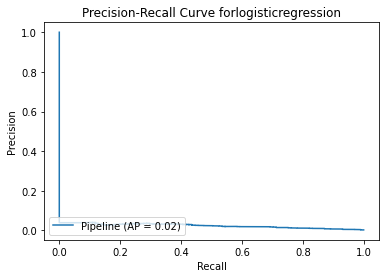

<Figure size 864x864 with 0 Axes>

randomforestclassifier
{'Best param': {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 50}, 'Best estimator': Pipeline(steps=[('nearmiss', NearMiss(sampling_strategy='majority')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=4, n_estimators=50))]), 'Best training score': 0.9663854944519036, 'Model': RandomForestClassifier(), 'Best testing score': 0.9702970297029703}
Train Result:
              precision    recall  f1-score   support

           0       1.00      0.40      0.57    227454
           1       0.00      0.97      0.01       391

    accuracy                           0.40    227845
   macro avg       0.50      0.68      0.29    227845
weighted avg       1.00      0.40      0.57    227845



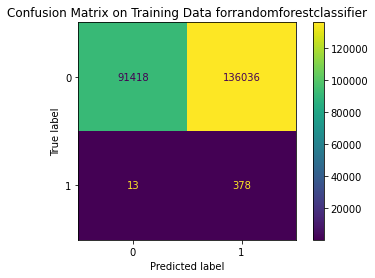

<Figure size 864x864 with 0 Axes>

Test Result:
              precision    recall  f1-score   support

           0       1.00      0.40      0.57     56861
           1       0.00      0.98      0.01       101

    accuracy                           0.40     56962
   macro avg       0.50      0.69      0.29     56962
weighted avg       1.00      0.40      0.57     56962



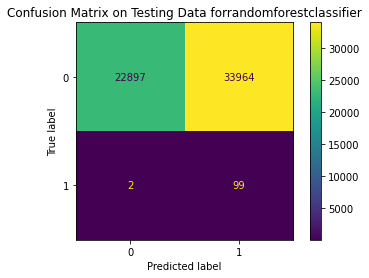

<Figure size 864x864 with 0 Axes>

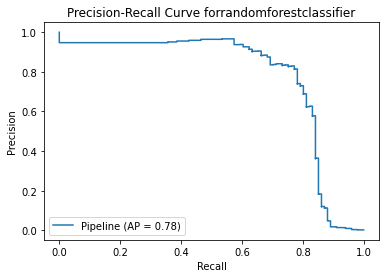

<Figure size 864x864 with 0 Axes>

adaboostclassifier
{'Best param': {'adaboostclassifier__n_estimators': 10}, 'Best estimator': Pipeline(steps=[('nearmiss', NearMiss(sampling_strategy='majority')),
                ('adaboostclassifier', AdaBoostClassifier(n_estimators=10))]), 'Best training score': 0.9586821481769241, 'Model': AdaBoostClassifier(), 'Best testing score': 1.0}
Train Result:
              precision    recall  f1-score   support

           0       1.00      0.35      0.52    227454
           1       0.00      0.97      0.01       391

    accuracy                           0.35    227845
   macro avg       0.50      0.66      0.26    227845
weighted avg       1.00      0.35      0.52    227845



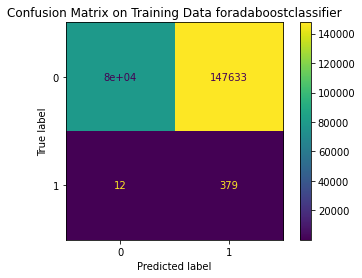

<Figure size 864x864 with 0 Axes>

Test Result:
              precision    recall  f1-score   support

           0       1.00      0.35      0.51     56861
           1       0.00      0.97      0.01       101

    accuracy                           0.35     56962
   macro avg       0.50      0.66      0.26     56962
weighted avg       1.00      0.35      0.51     56962



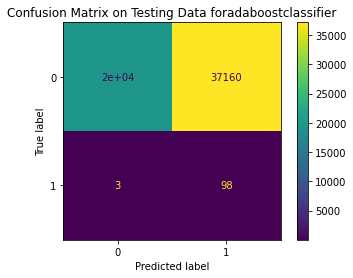

<Figure size 864x864 with 0 Axes>

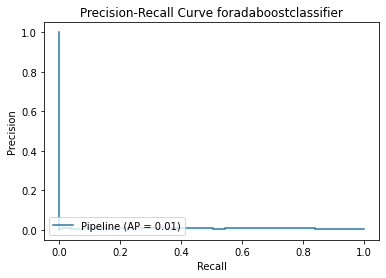

<Figure size 864x864 with 0 Axes>

svc
{'Best param': {'svc__C': 0.5, 'svc__kernel': 'linear', 'svc__probability': True}, 'Best estimator': Pipeline(steps=[('nearmiss', NearMiss(sampling_strategy='majority')),
                ('svc', SVC(C=0.5, kernel='linear', probability=True))]), 'Best training score': 0.9514189238820697, 'Model': SVC(), 'Best testing score': 0.9306930693069307}
Train Result:
              precision    recall  f1-score   support

           0       1.00      0.53      0.70    227454
           1       0.00      0.96      0.01       391

    accuracy                           0.54    227845
   macro avg       0.50      0.75      0.35    227845
weighted avg       1.00      0.54      0.70    227845



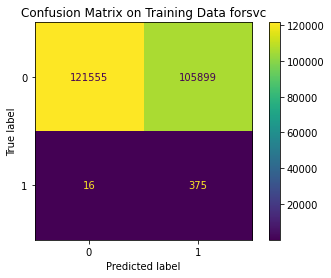

<Figure size 864x864 with 0 Axes>

Test Result:
              precision    recall  f1-score   support

           0       1.00      0.54      0.70     56861
           1       0.00      0.98      0.01       101

    accuracy                           0.54     56962
   macro avg       0.50      0.76      0.35     56962
weighted avg       1.00      0.54      0.70     56962



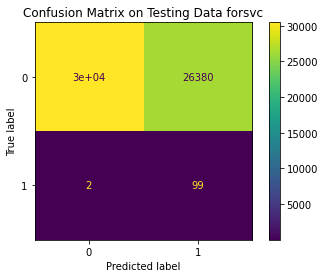

<Figure size 864x864 with 0 Axes>

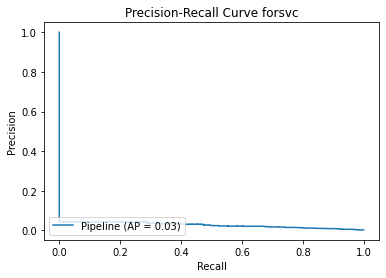

<Figure size 864x864 with 0 Axes>

xgbclassifier
{'Best param': {'xgbclassifier__gamma': 0.001, 'xgbclassifier__max_depth': 4}, 'Best estimator': Pipeline(steps=[('nearmiss', NearMiss(sampling_strategy='majority')),
                ('xgbclassifier', XGBClassifier(gamma=0.001, max_depth=4))]), 'Best training score': 0.9664215402300417, 'Model': XGBClassifier(), 'Best testing score': 0.9702970297029703}
Train Result:
              precision    recall  f1-score   support

           0       1.00      0.27      0.43    227454
           1       0.00      0.99      0.00       391

    accuracy                           0.27    227845
   macro avg       0.50      0.63      0.22    227845
weighted avg       1.00      0.27      0.43    227845



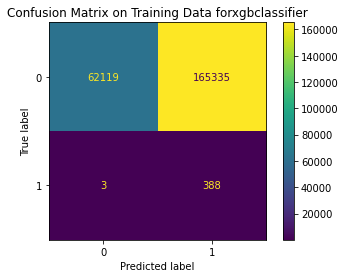

<Figure size 864x864 with 0 Axes>

Test Result:
              precision    recall  f1-score   support

           0       1.00      0.27      0.43     56861
           1       0.00      0.99      0.00       101

    accuracy                           0.27     56962
   macro avg       0.50      0.63      0.22     56962
weighted avg       1.00      0.27      0.43     56962



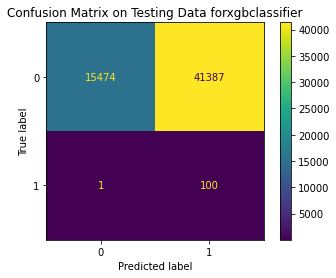

<Figure size 864x864 with 0 Axes>

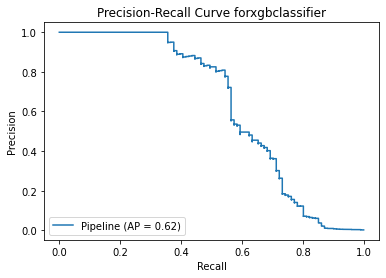

<Figure size 864x864 with 0 Axes>

kneighborsclassifier
{'Best param': {'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 2}, 'Best estimator': Pipeline(steps=[('nearmiss', NearMiss(sampling_strategy='majority')),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=2))]), 'Best training score': 0.9150393436639321, 'Model': KNeighborsClassifier(), 'Best testing score': 0.9405940594059405}
Train Result:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    227454
           1       0.01      0.94      0.02       391

    accuracy                           0.82    227845
   macro avg       0.50      0.88      0.46    227845
weighted avg       1.00      0.82      0.90    227845



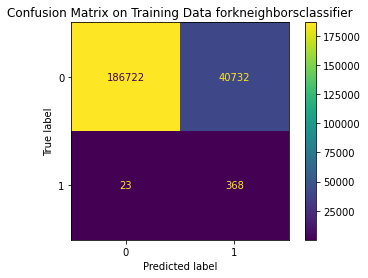

<Figure size 864x864 with 0 Axes>

Test Result:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     56861
           1       0.01      0.96      0.02       101

    accuracy                           0.82     56962
   macro avg       0.50      0.89      0.46     56962
weighted avg       1.00      0.82      0.90     56962



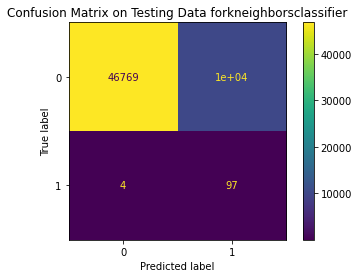

<Figure size 864x864 with 0 Axes>

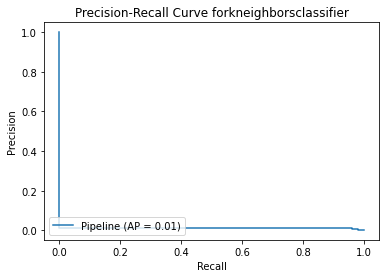

<Figure size 864x864 with 0 Axes>

In [25]:
kf = KFold(n_splits=3, random_state=42, shuffle=False)
best_param_model = { i[0] : {} for i in classifiers}

for i, model in zip(list(range(len(classifiers))), classifiers):
    score = {'accuracy' : [],
             'precision' : [],
             'recall' : [],
             'f1' : []
            }
    print(model[0])
    # to get the accuracy, precision, recall, f1 score of each fold and append to score list
    for train_fold_index,val_fold_index in kf.split(x_train,y_train):
        x_train_fold, y_train_fold = x_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
        x_val_fold, y_val_fold = x_train.iloc[val_fold_index], y_train.iloc[val_fold_index]
        pipeline = model_dict[model[0]]['Best estimator']
        best_model = pipeline.fit(x_train_fold,y_train_fold)
        
        y_pred = model_dict[model[0]]['Best estimator'].named_steps[model[0]].predict(x_val_fold)
        
        score['accuracy'].append(pipeline.score(x_val_fold,y_val_fold))
        score['precision'].append(precision_score(y_val_fold, y_pred))
        score['recall'].append(recall_score(y_val_fold, y_pred))
        score['f1'].append(f1_score(y_val_fold,y_pred))
        
    # to get the average score
    for key, ls in score.items():
        best_param_model[model[0]][key] = np.mean(ls)
        
    # Classification Report for Train data
    print(model_dict[model[0]])
    train_prediction = model_dict[model[0]]['Best estimator'].predict(x_train)
    test_prediction = model_dict[model[0]]['Best estimator'].predict(x_test)
    print('Train Result:')
    print(classification_report(y_train,train_prediction))
    # Confusion Matrix for Train data
    metrics.plot_confusion_matrix(model_dict[model[0]]['Best estimator'],x_train, y_train)
    plt.title('Confusion Matrix on Training Data for' +  model[0])
    plt.figure(figsize=(12,12))
    plt.show()
    # Classification Report for Test data
    print('Test Result:')
    print(classification_report(y_test,test_prediction))
     # Confusion Matrix for Test data
    metrics.plot_confusion_matrix(model_dict[model[0]]['Best estimator'],x_test, y_test)
    plt.title('Confusion Matrix on Testing Data for' +  model[0])
    plt.figure(figsize=(12,12))
    plt.show()
   # Precision-Recall Curve for test data
    probs = model_dict[model[0]]['Best estimator'].predict_proba(x_test)[:,1]
    average_precision = metrics.average_precision_score(y_test,probs)
    metrics.plot_precision_recall_curve(model_dict[model[0]]['Best estimator'],x_test,y_test)
    plt.title('Precision-Recall Curve for' +  model[0])
    plt.figure(figsize=(12,12))
    plt.show()
    
        

In [26]:
best_param_model

{'logisticregression': {'accuracy': 0.5326295597865448,
  'precision': 0.0034664468560700657,
  'recall': 0.9465527438334078,
  'f1': 0.006907442948523482},
 'randomforestclassifier': {'accuracy': 0.210257444888477,
  'precision': 0.0021635471611554085,
  'recall': 0.958350163531214,
  'f1': 0.004316858011532018},
 'adaboostclassifier': {'accuracy': 0.3059452033734987,
  'precision': 0.0023755289650079212,
  'recall': 0.9586821481769241,
  'f1': 0.004739250489434222},
 'svc': {'accuracy': 0.49876868661315515,
  'precision': 0.0033104075855579854,
  'recall': 0.9514189238820697,
  'f1': 0.006597244046397573},
 'xgbclassifier': {'accuracy': 0.18468726918615266,
  'precision': 0.002047414919077626,
  'recall': 0.9664215402300417,
  'f1': 0.004086064585109592},
 'kneighborsclassifier': {'accuracy': 0.7717832701412917,
  'precision': 0.007437679734291379,
  'recall': 0.9150393436639321,
  'f1': 0.014746352310070926}}

### Method 2 Summary:
As this dataset is highly imbalanced, instead of using ROC Curve, I used Precision-Recall Curve to measure the effectiveness of the models. Apart from AP score, I also looked into the f1 score.

The f1 score is  too low. As there are too many false negatives, the models are too sensitive towards fraud. It will bring a lot of inconvenience to credit users as transactions are identified as fraud frequently.  

In the coming steps, I am going to try out over sampling techniques to see if i can get a higher average precision score using oversampling techniques.

## Step 5.3 -  Method 3: Oversampling within Folds
I used SMOTE to oversample only the minoirity class (i.e. Fraud). Synthetic Minority Oversampling Technique (SMOTE) firstly identifies the feature vector and its nearest neighbor. After that,  it calculates the difference between the two identified points and then multiplies the difference with a random number between 0 and 1. A new point is finally identified on the line segment by adding the random number to the feature vector. The whole process is repeated until the number of data points of minority class equals to that of majority class.
- Reference
    - https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/

In [95]:
x = new_df.drop('Class',axis=1)
y = new_df['Class']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [73]:
classifiers = [
    ('logisticregression', LogisticRegression(),
     {'penalty': ['l1','l2'], 'C':[0.001,0.01,0.1,1,10,100,1000]}),
    ('randomforestclassifier',RandomForestClassifier(),
    {'n_estimators':[30,40,50],'max_depth': list(range(2,5))}),
    ('adaboostclassifier',AdaBoostClassifier(), {'n_estimators':[10,20,30,40,50,60]}),
    ('xgbclassifier', XGBClassifier(),{'max_depth':list(range(2,5)),'gamma':[0.001,0.01,0.1,1]}),
    ('kneighborsclassifier', KNeighborsClassifier(),
     {'n_neighbors': list(range(2,11,2)), 'algorithm':['ball_tree','kd_tree','brute']}),
    
]

logisticregression
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   12.9s finished
/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the dat

{'Best param': {'logisticregression__penalty': 'l2', 'logisticregression__C': 10}, 'Best estimator': Pipeline(steps=[('smote', SMOTE(sampling_strategy='minority')),
                ('logisticregression', LogisticRegression(C=10))]), 'Best training score': 0.9728104632535276, 'Model': LogisticRegression(), 'Best testing score': 0.9405940594059405}
Train Result:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    227454
           1       0.05      0.91      0.10       391

    accuracy                           0.97    227845
   macro avg       0.53      0.94      0.54    227845
weighted avg       1.00      0.97      0.98    227845



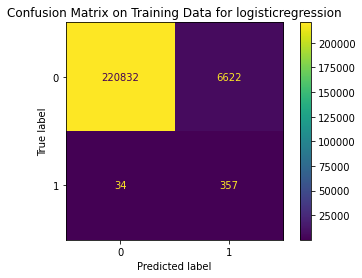

<Figure size 864x864 with 0 Axes>

Test Result:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56861
           1       0.06      0.94      0.10       101

    accuracy                           0.97     56962
   macro avg       0.53      0.96      0.54     56962
weighted avg       1.00      0.97      0.98     56962



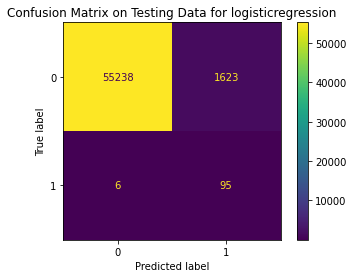

<Figure size 864x864 with 0 Axes>

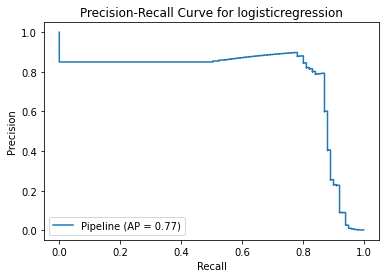

<Figure size 864x864 with 0 Axes>

randomforestclassifier
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.2min finished


{'Best param': {'randomforestclassifier__n_estimators': 40, 'randomforestclassifier__max_depth': 2}, 'Best estimator': Pipeline(steps=[('smote', SMOTE(sampling_strategy='minority')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=2, n_estimators=40))]), 'Best training score': 0.9959753341087142, 'Model': RandomForestClassifier(), 'Best testing score': 0.900990099009901}
Train Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       0.37      0.84      0.52       391

    accuracy                           1.00    227845
   macro avg       0.69      0.92      0.76    227845
weighted avg       1.00      1.00      1.00    227845



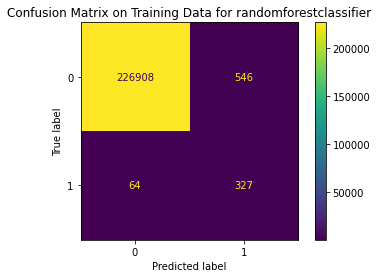

<Figure size 864x864 with 0 Axes>

Test Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.40      0.88      0.55       101

    accuracy                           1.00     56962
   macro avg       0.70      0.94      0.78     56962
weighted avg       1.00      1.00      1.00     56962



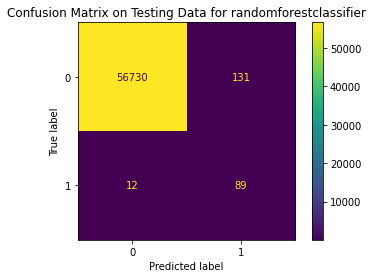

<Figure size 864x864 with 0 Axes>

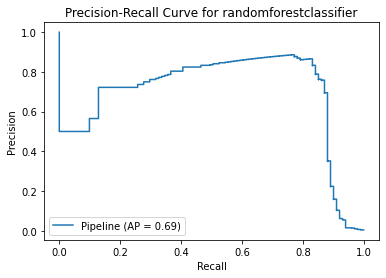

<Figure size 864x864 with 0 Axes>

adaboostclassifier
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.7min finished


{'Best param': {'adaboostclassifier__n_estimators': 60}, 'Best estimator': Pipeline(steps=[('smote', SMOTE(sampling_strategy='minority')),
                ('adaboostclassifier', AdaBoostClassifier(n_estimators=60))]), 'Best training score': 0.9813513572823629, 'Model': AdaBoostClassifier(), 'Best testing score': 0.8910891089108911}
Train Result:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    227454
           1       0.08      0.93      0.14       391

    accuracy                           0.98    227845
   macro avg       0.54      0.96      0.57    227845
weighted avg       1.00      0.98      0.99    227845



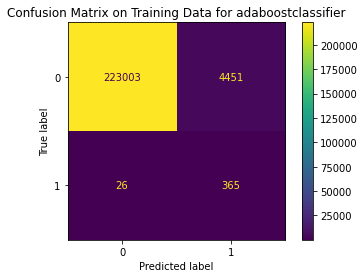

<Figure size 864x864 with 0 Axes>

Test Result:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56861
           1       0.07      0.87      0.13       101

    accuracy                           0.98     56962
   macro avg       0.54      0.93      0.56     56962
weighted avg       1.00      0.98      0.99     56962



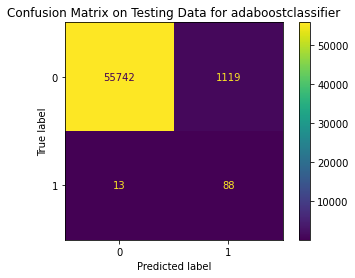

<Figure size 864x864 with 0 Axes>

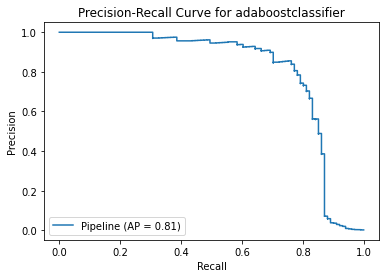

<Figure size 864x864 with 0 Axes>

xgbclassifier
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.8min finished


{'Best param': {'xgbclassifier__max_depth': 3, 'xgbclassifier__gamma': 1}, 'Best estimator': Pipeline(steps=[('smote', SMOTE(sampling_strategy='minority')),
                ('xgbclassifier', XGBClassifier(gamma=1))]), 'Best training score': 0.9886019004147556, 'Model': XGBClassifier(), 'Best testing score': 0.900990099009901}
Train Result:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    227454
           1       0.15      0.95      0.26       391

    accuracy                           0.99    227845
   macro avg       0.58      0.97      0.63    227845
weighted avg       1.00      0.99      0.99    227845



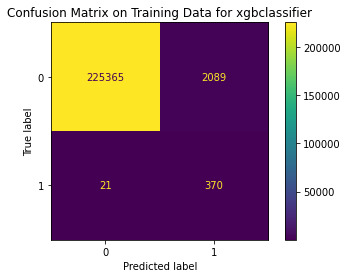

<Figure size 864x864 with 0 Axes>

Test Result:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56861
           1       0.15      0.89      0.25       101

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.63     56962
weighted avg       1.00      0.99      0.99     56962



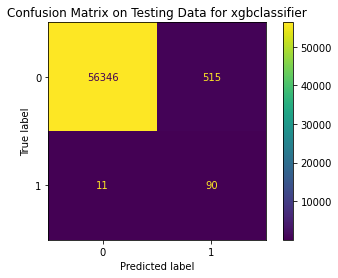

<Figure size 864x864 with 0 Axes>

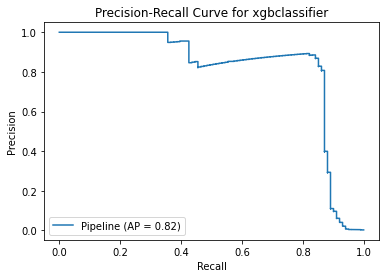

<Figure size 864x864 with 0 Axes>

kneighborsclassifier
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 26.0min finished


{'Best param': {'kneighborsclassifier__n_neighbors': 2, 'kneighborsclassifier__algorithm': 'ball_tree'}, 'Best estimator': Pipeline(steps=[('smote', SMOTE(sampling_strategy='minority')),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=2))]), 'Best training score': 0.9990651539423732, 'Model': KNeighborsClassifier(), 'Best testing score': 0.8712871287128713}
Train Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       0.87      0.94      0.90       391

    accuracy                           1.00    227845
   macro avg       0.93      0.97      0.95    227845
weighted avg       1.00      1.00      1.00    227845



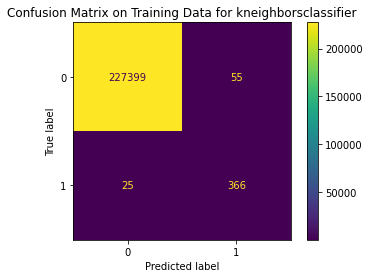

<Figure size 864x864 with 0 Axes>

Test Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.70      0.86      0.77       101

    accuracy                           1.00     56962
   macro avg       0.85      0.93      0.88     56962
weighted avg       1.00      1.00      1.00     56962



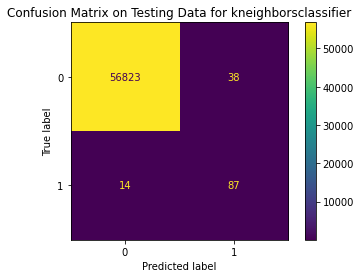

<Figure size 864x864 with 0 Axes>

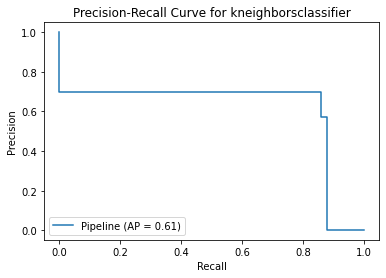

<Figure size 864x864 with 0 Axes>

In [32]:
kf = KFold(n_splits=3, random_state=42, shuffle=False)
model_dict = {}
best_param_model = { i[0] : {} for i in classifiers}
for i, model in zip(list(range(len(classifiers))), classifiers):
    print(model[0])
    imba_pipeline = make_pipeline(SMOTE(sampling_strategy='minority'), model[1])
    new_params = {model[0] + '__' + key : model[2][key] for key in model[2] }
    grid_imba = RandomizedSearchCV(imba_pipeline,new_params, n_iter=3,random_state=42, verbose=1, n_jobs=-1)
    grid_imba.fit(x_train,y_train)
    model_dict[model[0]] = {'Best param': grid_imba.best_params_,
                           'Best estimator': grid_imba.best_estimator_,
                           'Best training score' : grid_imba.best_score_,
                           'Model': model[1],
                           'Best testing score': recall_score(y_test,grid_imba.predict(x_test))}

    score = {'accuracy' : [],
             'precision' : [],
             'recall' : [],
             'f1' : []
            }
    for train_fold_index,val_fold_index in kf.split(x_train,y_train):
        x_train_fold, y_train_fold = x_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
        x_val_fold, y_val_fold = x_train.iloc[val_fold_index], y_train.iloc[val_fold_index]
        pipeline = model_dict[model[0]]['Best estimator']
        pipeline.fit(x_train_fold,y_train_fold)
        
        y_pred = pipeline.predict(x_val_fold)
        
        score['accuracy'].append(pipeline.score(x_val_fold,y_val_fold))
        score['precision'].append(precision_score(y_val_fold, y_pred))
        score['recall'].append(recall_score(y_val_fold, y_pred))
        score['f1'].append(f1_score(y_val_fold,y_pred))
   
    for key, ls in score.items():
        best_param_model[model[0]][key] = np.mean(ls)
    
    print(model_dict[model[0]])
    train_prediction = model_dict[model[0]]['Best estimator'].predict(x_train)
    test_prediction = model_dict[model[0]]['Best estimator'].predict(x_test)
    print('Train Result:')
    print(classification_report(y_train,train_prediction))
    
    metrics.plot_confusion_matrix(model_dict[model[0]]['Best estimator'],x_train, y_train)
    plt.title('Confusion Matrix on Training Data for ' +  model[0])
    plt.figure(figsize=(12,12))
    plt.show()
    
    print('Test Result:')
    print(classification_report(y_test,test_prediction))
    metrics.plot_confusion_matrix(model_dict[model[0]]['Best estimator'],x_test, y_test)
    plt.title('Confusion Matrix on Testing Data for ' +  model[0])
    plt.figure(figsize=(12,12))
    plt.show()
    
    probs = model_dict[model[0]]['Best estimator'].predict_proba(x_test)[:,1]
    average_precision = metrics.average_precision_score(y_test,probs)
    metrics.plot_precision_recall_curve(model_dict[model[0]]['Best estimator'],x_test,y_test)
    plt.title('Precision-Recall Curve for ' +  model[0])
    plt.figure(figsize=(12,12))
    plt.show()
    
    

### Method 3 Summary
With same result as method 2, the model has low precision score. The positive recall score is increased at the expense of more misclassified results. As recall score focuses on minimising false negatives (i.e. Non-Fraud transactions are identified as Fraud), it is acceptable that the precision score is low in this case. 

Among these models, XGBoostClassifier seems to have the best score although the precision score is still low. Less than 1% of non-fraud transactions will be identified as fraud-transactions while 10% of fraud transactions cannot be spotted by this model.

Next time, instead of using sampling_strategy='minority', maybe I can work on Smote ratios to fine tune the class weights so that I can achieve better precision score and further reduce false positive.
##### Remarks:
I decided to skip the training for SVC in order  to save some time. To speed up the cross validation process, I used RandomizedSearchCV to find the best parameter for each model.
##### Reference:
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/


## Step 5.4 -  Method 4: Oversampling using Model Class Weight
Application of class weight is simple. It add bias to the model in order to enhance the predictions of higher weighted class over the one with lower weight.
- Reference:
    - https://datascience.stackexchange.com/questions/52627/why-class-weight-is-outperforming-oversampling

In [33]:
x = new_df.drop('Class',axis=1)
y = new_df['Class']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [34]:
classifiers = [
    ('logisticregression', LogisticRegression(),
     {'penalty': ['l1','l2'], 'C':[0.001,0.01,0.1,1,10,100,1000], 'class_weight': [{0:1,1:1},{0:1,1:5},{0:1,1:10},{0:1,1:100}]}),
    ('randomforestclassifier',RandomForestClassifier(),
    {'n_estimators':[30,40,50],'max_depth': list(range(2,5)),'class_weight': [{0:1,1:1},{0:1,1:5},{0:1,1:10},{0:1,1:100}]}),
    ('adaboostclassifier',AdaBoostClassifier(), {'n_estimators':[10,20,30,40,50,60]}),
    ('xgbclassifier', XGBClassifier(),{'max_depth':list(range(2,5)),'gamma':[0.001,0.01,0.1,1]}),
    ('kneighborsclassifier', KNeighborsClassifier(), 
     {'n_neighbors': list(range(2,11,2)), 'algorithm':['ball_tree','kd_tree','brute']})
]
      

logisticregression
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/mushroom/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.1s finished


{'Best param': {'penalty': 'l2', 'class_weight': {0: 1, 1: 10}, 'C': 0.001}, 'Best estimator': LogisticRegression(C=0.001, class_weight={0: 1, 1: 10}), 'Best training score': 0.9992670455792314, 'Model': LogisticRegression(), 'Best testing score': 0.8415841584158416}
Train Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       0.78      0.79      0.79       391

    accuracy                           1.00    227845
   macro avg       0.89      0.90      0.89    227845
weighted avg       1.00      1.00      1.00    227845



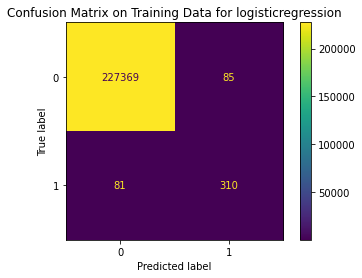

<Figure size 864x864 with 0 Axes>

Test Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.78      0.84      0.81       101

    accuracy                           1.00     56962
   macro avg       0.89      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962



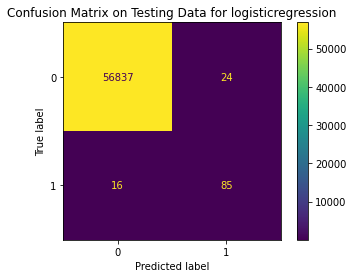

<Figure size 864x864 with 0 Axes>

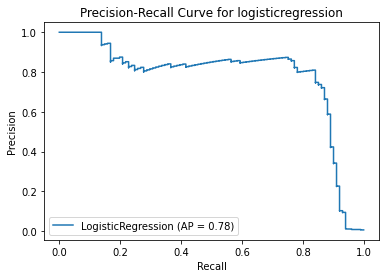

<Figure size 864x864 with 0 Axes>

randomforestclassifier
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   44.8s finished


{'Best param': {'n_estimators': 50, 'max_depth': 4, 'class_weight': {0: 1, 1: 10}}, 'Best estimator': RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=4, n_estimators=50), 'Best training score': 0.9993899361407974, 'Model': RandomForestClassifier(), 'Best testing score': 0.8316831683168316}
Train Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       0.87      0.80      0.83       391

    accuracy                           1.00    227845
   macro avg       0.94      0.90      0.92    227845
weighted avg       1.00      1.00      1.00    227845



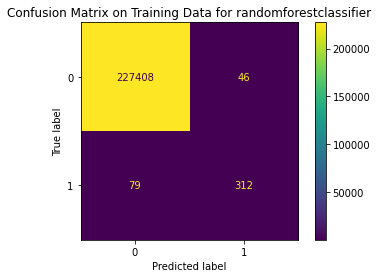

<Figure size 864x864 with 0 Axes>

Test Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.87      0.82      0.85       101

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



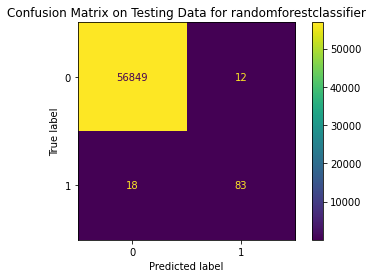

<Figure size 864x864 with 0 Axes>

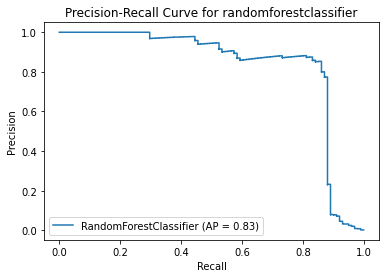

<Figure size 864x864 with 0 Axes>

adaboostclassifier
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.2min finished


{'Best param': {'n_estimators': 60}, 'Best estimator': AdaBoostClassifier(n_estimators=60), 'Best training score': 0.999297768219623, 'Model': AdaBoostClassifier(), 'Best testing score': 0.7722772277227723}
Train Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       0.85      0.70      0.77       391

    accuracy                           1.00    227845
   macro avg       0.92      0.85      0.88    227845
weighted avg       1.00      1.00      1.00    227845



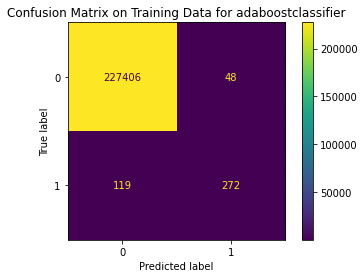

<Figure size 864x864 with 0 Axes>

Test Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.84      0.75      0.80       101

    accuracy                           1.00     56962
   macro avg       0.92      0.88      0.90     56962
weighted avg       1.00      1.00      1.00     56962



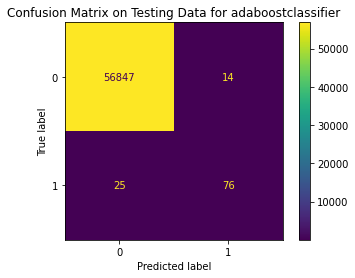

<Figure size 864x864 with 0 Axes>

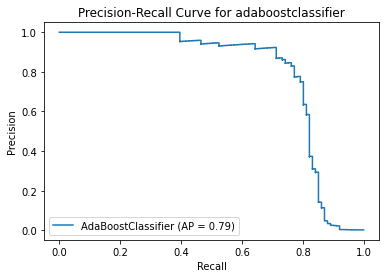

<Figure size 864x864 with 0 Axes>

xgbclassifier
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.0min finished


{'Best param': {'max_depth': 3, 'gamma': 1}, 'Best estimator': XGBClassifier(gamma=1), 'Best training score': 0.9994689372160899, 'Model': XGBClassifier(), 'Best testing score': 0.8415841584158416}
Train Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       0.95      0.83      0.88       391

    accuracy                           1.00    227845
   macro avg       0.97      0.91      0.94    227845
weighted avg       1.00      1.00      1.00    227845



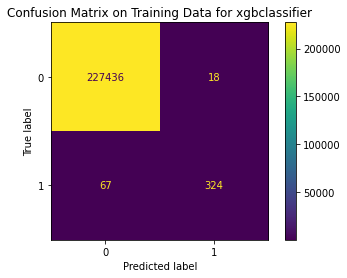

<Figure size 864x864 with 0 Axes>

Test Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.94      0.84      0.89       101

    accuracy                           1.00     56962
   macro avg       0.97      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962



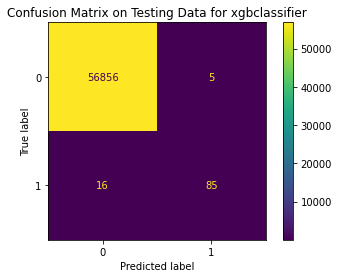

<Figure size 864x864 with 0 Axes>

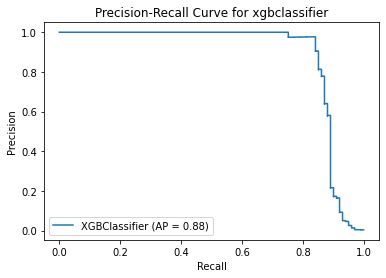

<Figure size 864x864 with 0 Axes>

kneighborsclassifier
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 18.1min finished


{'Best param': {'n_neighbors': 4, 'algorithm': 'brute'}, 'Best estimator': KNeighborsClassifier(algorithm='brute', n_neighbors=4), 'Best training score': 0.9994513814215805, 'Model': KNeighborsClassifier(), 'Best testing score': 0.801980198019802}
Train Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       0.97      0.75      0.85       391

    accuracy                           1.00    227845
   macro avg       0.98      0.88      0.92    227845
weighted avg       1.00      1.00      1.00    227845



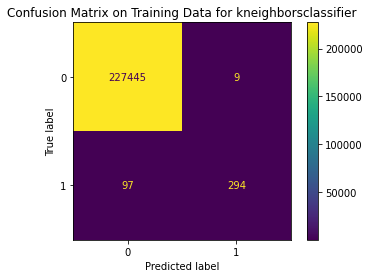

<Figure size 864x864 with 0 Axes>

Test Result:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.95      0.81      0.88       101

    accuracy                           1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



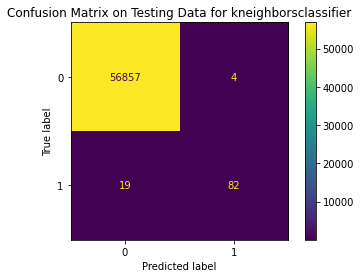

<Figure size 864x864 with 0 Axes>

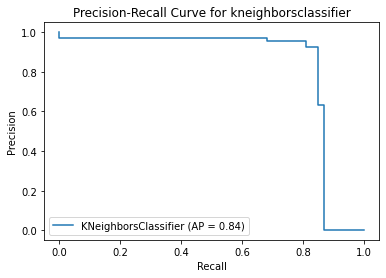

<Figure size 864x864 with 0 Axes>

In [37]:
kf = KFold(n_splits=5, random_state=42, shuffle=False)
model_dict = {}
best_param_model = { i[0] : {} for i in classifiers}
for i, model in zip(list(range(len(classifiers))), classifiers):
    print(model[0])
    new_params = { key : model[2][key] for key in model[2] }
    grid_imba = RandomizedSearchCV(model[1],new_params, n_iter=3,random_state=42, verbose=1, n_jobs=-1)
    #grid_imba = GridSearchCV(model[1], param_grid=new_params, cv=kf,return_train_score=True)
    grid_imba.fit(x_train,y_train)
    model_dict[model[0]] = {'Best param': grid_imba.best_params_,
                           'Best estimator': grid_imba.best_estimator_,
                           'Best training score' : grid_imba.best_score_,
                           'Model': model[1],
                           'Best testing score': recall_score(y_test,grid_imba.predict(x_test))}

    score = {'accuracy' : [],
             'precision' : [],
             'recall' : [],
             'f1' : []
            }
    for train_fold_index,val_fold_index in kf.split(x_train,y_train):
        x_train_fold, y_train_fold = x_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
        x_val_fold, y_val_fold = x_train.iloc[val_fold_index], y_train.iloc[val_fold_index]
        pipeline = model_dict[model[0]]['Best estimator']
        pipeline.fit(x_train_fold,y_train_fold)
        
        y_pred = pipeline.predict(x_val_fold)
        
        score['accuracy'].append(pipeline.score(x_val_fold,y_val_fold))
        score['precision'].append(precision_score(y_val_fold, y_pred))
        score['recall'].append(recall_score(y_val_fold, y_pred))
        score['f1'].append(f1_score(y_val_fold,y_pred))
   
    for key, ls in score.items():
        best_param_model[model[0]][key] = np.mean(ls)
    
    print(model_dict[model[0]])
    train_prediction = model_dict[model[0]]['Best estimator'].predict(x_train)
    test_prediction = model_dict[model[0]]['Best estimator'].predict(x_test)
    print('Train Result:')
    print(classification_report(y_train,train_prediction))
    
    metrics.plot_confusion_matrix(model_dict[model[0]]['Best estimator'],x_train, y_train)
    plt.title('Confusion Matrix on Training Data for ' +  model[0])
    plt.figure(figsize=(12,12))
    plt.show()
    
    print('Test Result:')
    print(classification_report(y_test,test_prediction))
    metrics.plot_confusion_matrix(model_dict[model[0]]['Best estimator'],x_test, y_test)
    plt.title('Confusion Matrix on Testing Data for ' +  model[0])
    plt.figure(figsize=(12,12))
    plt.show()
    
    probs = model_dict[model[0]]['Best estimator'].predict_proba(x_test)[:,1]
    average_precision = metrics.average_precision_score(y_test,probs)
    metrics.plot_precision_recall_curve(model_dict[model[0]]['Best estimator'],x_test,y_test)
    plt.title('Precision-Recall Curve for ' +  model[0])
    plt.figure(figsize=(12,12))
    plt.show()
    

### Method 4 Summary
XGBoost Classifier with a parameter of gamma = 1 performs the best. Incorrect fraud detection is almost 0% but there are 20% of the fraud transactions cannot be identified by this model, which is 2 times higher than that of xgbclassifier in method 3.  

# Conclusion
All in all, I think the best model goes to  xgbclassifier with a parameter of gamma=1 using SMOTE oversamling technique. Although method 4 seems to have the best  performance, the ablity of identifying fraud is not as good as method 3's. 

The company and cardholders will suffer from hugh financial loss if the model is not able to detect as much frauds as it can. Meanwhile, if the model is overly sensitive, it will annoy cardholders frequently and will eventually switch to another credit card service provider. It is important to strike balance between the recall score and precision score. 

Therefore, xgboost classifier with SMOTE is a better option as the false negative rate is still acceptable. Instead of blocking user's transactions once fraud is detected, the company could ask for further verification from customer so that it can reduce the inconvenience bought by wrong detections.